In [155]:
#In this notebook, you'll implement your first neural network.
#We're going to start with a simple 2-layer net, and work our way to more
#complex cases after that.

#First, let's get our data loaded.
import pickle
import numpy as np
from IPython.display import clear_output
from matplotlib import pyplot as plt
import collections
import copy
import time
%matplotlib inline

with open("testTrainLab2.pickle", "rb") as f:
    labData = pickle.load(f)

print("Confirm we have the expected 50,000 training Images:")
print(len(labData["X_train"]))
print(len(labData["y_train"]))

print("\nConfirm we have the expected 10,000 test Images:")
print(len(labData["X_test"]))
print(len(labData["y_test"]))

print("\nConfirm the first image in our training set is a 32x32x3 matrix of values, representing a 32x32 image with 3 bands of color:")
print(labData["X_train"][0].shape)
print(str(labData["X_train"][0].shape) == "(32, 32, 3)")

print("\nConfirm our y observations make sense - i.e., an integer between 0 and 9 representing one of the 10 classes in CIFAR")
print(max(labData["y_train"]))
print(min(labData["y_train"]))

#Get our X_train and X_test ready - we're still flattening the images into an array at this point.
#Note that later on (when we get to convolutions), we won't be flattening anymore.
#But, for now, we transform the CIFAR-10 images into long 1x3072 arrays (just like last lab).
X_train = np.reshape(labData["X_train"], (labData["X_train"].shape[0], -1))
X_test = np.reshape(labData["X_test"], (labData["X_test"].shape[0], -1))

y_train = labData["y_train"]
y_test = labData["y_test"]

Confirm we have the expected 50,000 training Images:
50000
50000

Confirm we have the expected 10,000 test Images:
10000
10000

Confirm the first image in our training set is a 32x32x3 matrix of values, representing a 32x32 image with 3 bands of color:
(32, 32, 3)
True

Confirm our y observations make sense - i.e., an integer between 0 and 9 representing one of the 10 classes in CIFAR
9
0


In [16]:
#We're going to implement our neural network using a class to keep things ordered / in one place.
#The first thing we'll define is how we want to initialize our weights - for now, random.
#We're also going to start timing our code, as runtimes are going to become relevant to you
#later in this assignment.

#The basic architecture we'll be implementing here is:

#(I) -> (H) -> (O)
#Where we're inputting CIFAR10 (I) into a hidden layer of a network (H), and then outputting our scores (O)
#We'll also be using multiplicative funcitons - i.e., we'll multiply our inputs by our weights.

class neuralNet():
    #When we initialize the network, we're going to ask the user set a few parameters.
    #These are annotated below
    def __init__(self, inputSize, hiddenSize, outputSize):
        self.startTime = time.time()
        self.inputSize = inputSize
        self.hiddenSize = hiddenSize
        self.outputSize = outputSize

        #We're also goign to create a library to hold all of the
        #weights and othe parameters we're going to need in this network:
        self.params = {}

    def initializeWeights(self, weightType="random"):
        #Here, we'll initialize the weights for our network.  
        #For now, we will only define a single approach (random).
        if(weightType == "random"):
            #The randn function returns a matrix of random number with the specified size.
            #You'll recall from lecture that the number of weights required to fit a
            #layer are equal to the inputs times the outputs of that layer - this is because
            #we're making a matrix that effectively connects each input to the layer output.
            #This is reflected in the below code - here, we're bulding two weights matrices - 
            #one for each layer in our simple net.
            self.params['W1'] = np.random.randn(self.inputSize, self.hiddenSize)
            self.params['W2'] = np.random.randn(self.hiddenSize, self.outputSize)
            
#Let's test our new class and see that the weights matrices are being intialized how we believe they should be.
#We're going to use a CIFAR image as an example here - i.e., we'll have 3072 inputs.
#The number of hidden nodes is arbitrary here, set to 15 for an example.  
#We'll keep that small for our example cases.
#Finally, oputput size is set to 10, representing the 10 classes in CIFAR-10.

myNet = neuralNet(inputSize = 3072, hiddenSize =15, outputSize = 10)

#Run our weights initialization code:
myNet.initializeWeights(weightType="random")

#Check the weights dimensions are as we expect (3072 by 15 for the first layer, 15 * 10 for the second):
print(myNet.params['W1'].shape)
print(myNet.params['W2'].shape)

#And, double check one row from each matrix just to be extra sure things are happening as we expect:
print(myNet.params['W1'][0])
print(myNet.params['W2'][0])



(3072, 15)
(15, 10)
[ 0.27499816 -0.42547161  0.2524959  -0.12950091  0.01524306  0.72995652
  0.09058115  2.24096065  0.25569788 -1.5789486  -0.18972154  0.57265836
 -0.72705462 -1.22134258 -0.26589835]
[-0.61630614 -0.2819512  -1.23634287  0.38418757 -1.04139464  0.038658
 -0.68078669  0.4077981  -0.3587783   0.23782806]


In [36]:

#Now, we're going to build on our first model to implement
#a forward pass.  
#For this case, let's load a few of our CIFAR-10 images.



class neuralNet():
    def __init__(self, inputSize, hiddenSize, outputSize):
        self.startTime = time.time()
        self.inputSize = inputSize
        self.hiddenSize = hiddenSize
        self.outputSize = outputSize
        self.params = {}

    def initializeWeights(self, weightType="random"):
        if(weightType == "random"):
            self.params['W1'] = np.random.randn(self.inputSize, self.hiddenSize)
            self.params['W2'] = np.random.randn(self.hiddenSize, self.outputSize)

    def forwardPass(self, X):
        #Ok - here is the first layer. 
        #We multiple each of the weights W1 by our input X.
        #In our case, the input is a 3072 x 1 array;
        #The parameters W1 is a 3072 x 15 matrix of weights.
        #The first output will be the array multiplied by the weights matrix:
        hiddenLayerValues = np.dot(X, self.params['W1'])
        #The above line of code represents the outputs at the hidden layer stage.
        
        #Now, we need to multiply again - this time taking our weights and collapsing them down to
        #the final 10 scores:
        scores = np.dot(hiddenLayerValues, self.params['W2'])
        self.scores = scores


#Let's test it out:
myNet = neuralNet(inputSize = 3072, hiddenSize =15, outputSize = 10)
myNet.initializeWeights(weightType="random")
myNet.forwardPass(X_train[0])

#Here, we'll get our 10 scores out - each representing one of the CIFAR-10 classes.
#Of course, right now these scores are just random noise (we're multiplying the image input by
# random values, after all.)  Our goal is now to optimize our two sets of weights
#parameters (W1 and W2) to make these scores meaningful.
print(myNet.scores)

[ 15521.47737052  24214.28924473 -28378.8052831  -17696.82780341
   5066.19034051 -32875.5882669    5997.57637564 -16247.35889043
  36968.32836674  44837.49387276]


In [111]:
#The first step in optimizing our weight parameters is to calculate our loss.
#We'll start with something simple for now, just calculating the SVM Multiclass Loss
#(Just like last lab!)

class neuralNet():
    def __init__(self, inputSize, hiddenSize, outputSize):
        self.startTime = time.time()
        self.inputSize = inputSize
        self.hiddenSize = hiddenSize
        self.outputSize = outputSize
        self.params = {}

    def initializeWeights(self, weightType="random"):
        if(weightType == "random"):
            self.params['W1'] = np.random.randn(self.inputSize, self.hiddenSize)
            self.params['W2'] = np.random.randn(self.hiddenSize, self.outputSize)

    def forwardPass(self, X):
        self.hiddenLayerValues = np.dot(X, self.params['W1'])
        self.scores = np.dot(self.hiddenLayerValues, self.params['W2'])
    
    def Loss(self, X, y, type="svmMulticlass", lossParams = None):
        #As before, let's code this so we can handle multiple loss functions one day.
        if(type == "svmMulticlass"):
            #svm loss will require the epsilon paramter to be set.
            e = lossParams["epsilon"]
            
            #We're assuming X is a single observation (i.e., one CIFAR-10 image), for now.
            #We'll complicate that more later on (i.e., enable batches)
            countSamples = 1
            countClasses = 10

            #All of this is directly from the last assignment, with a few minor modifications
            #to handle the fact that our y input is just one image for this example.
            trueClassScores = self.scores[y]
            trueClassMatrix = np.matrix(trueClassScores).T
            correct = np.mean(np.equal(trueClassScores, np.amax(self.scores)))
            loss_ij = np.maximum(0, self.scores - trueClassMatrix + e)
            loss_ij[np.arange(countSamples), y] = 0
            self.dataLoss = np.sum(np.sum(loss_ij)) / countSamples

   
myNet = neuralNet(inputSize = 3072, hiddenSize =15, outputSize = 10)
myNet.initializeWeights(weightType="random")
myNet.forwardPass(X_train[0])
myNet.Loss(X = X_train[0], y = y_train[0], type="svmMulticlass", lossParams={'epsilon':1})
print(myNet.dataLoss)

167693.97212741897


In [153]:
#Now, let's compute our gradients through backpropogation.

class neuralNet():
    def __init__(self, inputSize, hiddenSize, outputSize):
        self.startTime = time.time()
        self.inputSize = inputSize
        self.hiddenSize = hiddenSize
        self.outputSize = outputSize
        self.params = {}
        self.gradients = {}

    def initializeWeights(self, weightType="random"):
        if(weightType == "random"):
            self.params['W1'] = np.random.randn(self.inputSize, self.hiddenSize)
            self.params['W2'] = np.random.randn(self.hiddenSize, self.outputSize)

    def forwardPass(self, X):
        self.hiddenLayerValues = np.dot(X, self.params['W1'])
        self.scores = self.hiddenLayerValues.dot(self.params['W2'])
        
    
    def Loss(self, X, y, type="svmMulticlass", lossParams = None):
        if(type == "svmMulticlass"):
            e = lossParams["epsilon"]
            countSamples = 1
            countClasses = 10
            trueClassScores = self.scores[y]
            trueClassMatrix = np.matrix(trueClassScores).T
            correct = np.mean(np.equal(trueClassScores, np.amax(self.scores)))
            loss_ij = np.maximum(0, self.scores - trueClassMatrix + e)
            loss_ij[np.arange(countSamples), y] = 0
            self.loss_ij = loss_ij
            self.dataLoss = np.sum(np.sum(loss_ij)) / countSamples
    
    def backwardPass(self, X, y):
        gradients = {}
        #Following the chain rule, we need to back-propogate the loss we find to adjust the 
        #gradients for our two weights inputs (W1 and W2).
        
        #The first intermediate step we need to figure out is - when a given output score changes -
        #what the expected change in our dataLoss would be.
        #This has to do with our loss function -i.e., here, we implemented a svmMulticlass loss function.
        #So, we need to differentiate our multiclass svm loss function with respect to our scores (s) as 
        #our first step.  

        #1) We create a matrix with binary 0 and 1
        svmMask = np.zeros(self.loss_ij.shape)
        svmMask[self.loss_ij > 0] = 1

        #2a) For the "true" scores, we put the sum of all the other columns - i.e., if our true score goes up by 1, the total loss value would change
        #by this amount.  Here, rowPostiveCount is literally just hte number of cases with a positive value in our loss_ij matrix - i.e., the number of
        #INCORRECT scores that were greater than the CORRECT scores this iteration.
        rowPostiveCount = np.sum(svmMask, axis=1)

        #2b) Now, we insert those sums into our "true" score values for the margin matrix. In this example, we're only passing one image at a time,
        #so this is pretty straightforward (note the -1, as the total loss will DECREASE as the true score value INCREASES):
        svmMask[np.arange(1), y] = -1 * rowPostiveCount

        #3) Finally, we multiply by our inputs.  For our first gradient, these inputs are our hidden layer values:
        #Note the asmatrix below - this is only necessary because we are operating with a single array in this example.
        #Also note there is no regularization in this example!
        self.gradients['W2'] = np.asmatrix(self.hiddenLayerValues).T.dot(svmMask)
           
        
        #Now we have the gradient for W2, but we need to also calculate the gradient for our hidden nodes.
        #I.e., if our hidden node values change, what the expected change in the loss would be.
        #Very similar to the solution for the weights gradient!
        self.gradients["hiddenLayer"] = np.dot(svmMask, self.params['W2'].T)

        #Now, we can backpropogate one more time to get the W1 gradient
        self.gradients['W1'] = np.dot(np.asmatrix(X).T, self.gradients["hiddenLayer"])


   
myNet = neuralNet(inputSize = 3072, hiddenSize =15, outputSize = 10)
myNet.initializeWeights(weightType="random")
myNet.forwardPass(X_train[0])
myNet.Loss(X = X_train[0], y = y_train[0], type="svmMulticlass", lossParams={'epsilon':1})
myNet.backwardPass(X = X_train[0], y = y_train[0])
print(myNet.gradients['W1'].shape)
print(myNet.gradients['W2'].shape)


(3072, 15)
(15, 10)


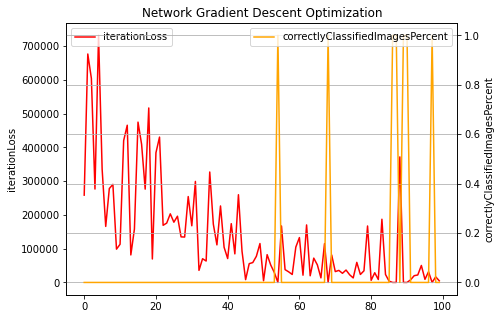

Runtime: 27.65534734725952


In [229]:

#Ok - we have nearly everything we need, now we just need to implement the training logic.
#This is the logic that will back and forward propogate and update our weights.
#At the end of this snippet, we'll have a fully functioning net, but a highly inefficient one that
#can only take in one image at a time from CIFAR.  

#Note that in your visualization, because this implementation feeds one image in at a time, for
#a given iteration you're either 100% correct, or 0% correct - there is no inbetween!

class neuralNet():
    def __init__(self, inputSize, hiddenSize, outputSize):
        self.startTime = time.time()
        self.inputSize = inputSize
        self.hiddenSize = hiddenSize
        self.outputSize = outputSize
        self.params = {}
        self.gradients = {}

    def initializeWeights(self, weightType="random"):
        if(weightType == "random"):
            self.params['W1'] = np.random.randn(self.inputSize, self.hiddenSize)
            self.params['W2'] = np.random.randn(self.hiddenSize, self.outputSize)

    def forwardPass(self, X):
        self.hiddenLayerValues = np.dot(X, self.params['W1'])
        self.scores = self.hiddenLayerValues.dot(self.params['W2'])
        
    
    def Loss(self, X, y, type="svmMulticlass", lossParams = None):
        if(type == "svmMulticlass"):
            e = lossParams["epsilon"]
            countSamples = 1
            countClasses = 10
            trueClassScores = self.scores[y]
            trueClassMatrix = np.matrix(trueClassScores).T
            self.correct = np.mean(np.equal(trueClassScores, np.amax(self.scores)))
            loss_ij = np.maximum(0, self.scores - trueClassMatrix + e)
            loss_ij[np.arange(countSamples), y] = 0
            self.loss_ij = loss_ij
            self.dataLoss = np.sum(np.sum(loss_ij)) / countSamples
    
    def backwardPass(self, X, y):
        gradients = {}
        svmMask = np.zeros(self.loss_ij.shape)
        svmMask[self.loss_ij > 0] = 1
        rowPostiveCount = np.sum(svmMask, axis=1)
        svmMask[np.arange(1), y] = -1 * rowPostiveCount
        self.gradients['W2'] = np.asmatrix(self.hiddenLayerValues).T.dot(svmMask)
        self.gradients["hiddenLayer"] = np.dot(svmMask, self.params['W2'].T)
        self.gradients['W1'] = np.dot(np.asmatrix(X).T, self.gradients["hiddenLayer"])


#Function for visualization copied from assignment 1:
def dynamicPlot(data_dict, figsize=(7,5), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    i = 0
    colors = ['red', 'deepskyblue', 'orange', 'green']]
    loc = ['upper left', 'upper right', 'lower left', 'lower right']
    for label,data in data_dict.items():
        plt.plot(data, label=label, color=colors[i])
        plt.ylabel(label)
        plt.legend(loc = loc[i])
        if(i == 0):
            plt.twinx()
        i = i + 1
    plt.title(title)
    plt.grid(True)
    plt.xlabel('Iteration')
    plt.show()

#Some parameters:
maxIterations = 100
learningRate = 1e-7

#Initialize our network
myNet = neuralNet(inputSize = 3072, hiddenSize =15, outputSize = 10)
myNet.initializeWeights(weightType="random")


currentIteration = 0
plotData = {}
plotData['iterationLoss'] = []
plotData['correctlyClassifiedImagesPercent'] = []

while currentIteration < maxIterations:
    #Forward Pass
    myNet.forwardPass(X_train[currentIteration])
    
    #Loss Calculations
    myNet.Loss(X = X_train[0], y = y_train[0], type="svmMulticlass", lossParams={'epsilon':1})

    #Backward Pass
    myNet.backwardPass(X = X_train[0], y = y_train[0])

    #Update Weights Based on Gradients
    myNet.params['W1'] += -learningRate*myNet.gradients['W1']
    myNet.params['W2'] += -learningRate*myNet.gradients['W2']
    
    #For visualizing our model behavior:
    plotData['iterationLoss'].append(myNet.dataLoss)
    plotData['correctlyClassifiedImagesPercent'].append(myNet.correct)
    dynamicPlot(plotData, title="Network Gradient Descent Optimization")
    currentIteration = currentIteration + 1

print("Runtime: " + str(time.time() - myNet.startTime))


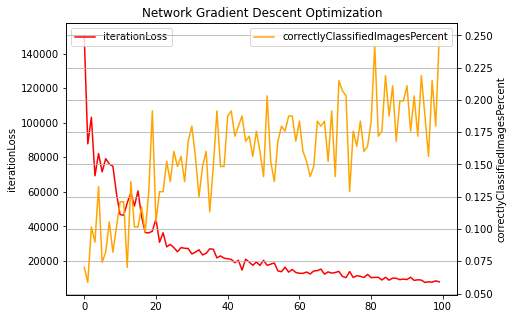

In [327]:

#Time for some cleanup.  Here, we're going to take the exact same function an make sure it is vectorized - i.e.,
#ready to take in multiple images per batch, rather than just one.

#We're also going to move a few functions around, as well as move the training inside the class.

class neuralNet():
    #First, we move most of our parameters into our init.
    #We're also going to go ahead and initialize our weights
    #here, so the user doesn't have to call a seperate function.
    #Also note we're allowing a user to input both X_train and X_test,
    #so we can have some validation later on.
    def __init__(self, inputSize, hiddenSize, outputSize, 
                X_train, y_train, X_test, y_test, 
                lossType = "svmMulticlass",
                lossParams = {"epsilon": 1},
                weightType = "random"):
        self.startTime = time.time()
        self.inputSize = inputSize
        self.hiddenSize = hiddenSize
        self.outputSize = outputSize
        self.params = {}
        self.gradients = {}
        self.lossType = lossType
        self.lossParams = lossParams
        self.weightType = "random"
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test

        if(self.weightType == "random"):
            self.params['W1'] = np.random.randn(self.inputSize, self.hiddenSize)
            self.params['W2'] = np.random.randn(self.hiddenSize, self.outputSize)

    #Now, we're going to wrap our forward, loss, and backward functions into one
    #".fit" function.  This ".fit" function will replace the while loop in the last
    #snipper as well.
    def fit(self, maxIterations, learningRate, batchSize, visualization=True):

               
        plotData = {}
        plotData['iterationLoss'] = []
        plotData['correctlyClassifiedImagesPercent'] = []
        
        currentIteration = 0
        while currentIteration < maxIterations:

            #This is new code - here, we're batching.
            #Essentially, following a stochastic gradient descent approach,
            #Here, we randomly select some number of X and Y observations (batchSize),
            #And use those for this iteration.
            randomSelection = np.random.randint(len(self.X_train), size=batchSize)
            xBatch = self.X_train[randomSelection,:]
            yBatch = self.y_train[randomSelection]

            #Forward Pass:
            self.hiddenLayerValues = np.dot(xBatch, self.params['W1'])
            self.scores = self.hiddenLayerValues.dot(self.params['W2'])

            #Loss - note a few changes here, so that we can input more than one image at a time:       
            if(self.lossType == "svmMulticlass"):
                e = self.lossParams["epsilon"]
                countSamples = len(xBatch)
                countClasses = self.scores.shape[0]
                trueClassScores = self.scores[np.arange(self.scores.shape[0]), yBatch]
                trueClassMatrix = np.matrix(trueClassScores).T
                self.correct = np.mean(np.equal(trueClassScores, np.amax(self.scores, axis=1)))
                loss_ij = np.maximum(0, self.scores - trueClassMatrix + e)
                loss_ij[np.arange(countSamples), yBatch] = 0
                self.loss_ij = loss_ij
                self.dataLoss = np.sum(np.sum(loss_ij)) / countSamples
            
            #Backward Pass - a few changes here as well to facilitate multiple-image inputs:
            gradients = {}
            svmMask = np.zeros(self.loss_ij.shape)
            svmMask[self.loss_ij > 0] = 1
            rowPostiveCount = np.sum(svmMask, axis=1)
            svmMask[np.arange(self.scores.shape[0]), yBatch] = -1 * rowPostiveCount
            self.gradients['W2'] = np.asmatrix(self.hiddenLayerValues).T.dot(svmMask)
            self.gradients["hiddenLayer"] = np.dot(svmMask, self.params['W2'].T)
            self.gradients['W1'] = np.dot(np.asmatrix(xBatch).T, self.gradients["hiddenLayer"])


            #Update Weights Based on Gradients
            self.params['W1'] += -learningRate*self.gradients['W1']
            self.params['W2'] += -learningRate*self.gradients['W2']
    
            #For visualizing our model behavior:
            plotData['iterationLoss'].append(self.dataLoss)
            plotData['correctlyClassifiedImagesPercent'].append(self.correct)
            self.dynamicPlot(plotData, title="Network Gradient Descent Optimization")

            currentIteration = currentIteration + 1

    def dynamicPlot(self, data_dict, figsize=(7,5), title=''):
        clear_output(wait=True)
        plt.figure(figsize=figsize)
        i = 0
        colors = ['red', 'deepskyblue', 'orange', 'green']
        loc = ['upper left', 'upper right', 'lower left', 'lower right']
        for label,data in data_dict.items():
            plt.plot(data, label=label, color=colors[i])
            plt.ylabel(label)
            plt.legend(loc = loc[i])
            if(i == 0):
                plt.twinx()
            i = i + 1
        plt.title(title)
        plt.grid(True)
        plt.xlabel('Iteration')
        plt.show()

    
myNet = neuralNet(inputSize = 3072, 
                  hiddenSize =15, 
                  outputSize = 10, 
                  X_train=X_train, 
                  y_train=y_train,
                  X_test=X_test,
                  y_test=y_test,
                  lossType = "svmMulticlass",
                  lossParams = {"epsilon": 1},
                  weightType = "random")

myNet.fit(maxIterations=100, learningRate = 1e-7, batchSize = 256, visualization=True)


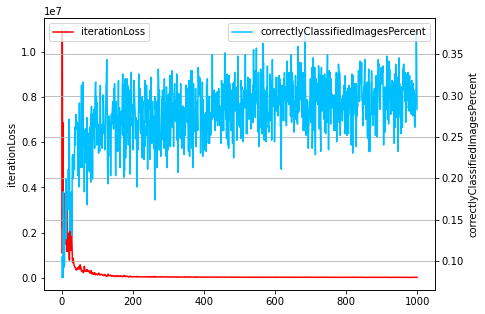

Best Training Dataset Accuracy: 38.0%
Final Iteration Accuracy: 28.000000000000004%
Test Dataset Accuracy: 28.08 %
Total Runtime: 34.83 seconds


In [329]:
#We're almost done, but we need to implement a test function, which in turn requires us to write a predict class.
#This will simply take our test data and report our final accuracy based on our fit.

#Note at this stage we also make a few minor changes to our plotting function so that rather than reporting as the model fits,
#we report everything at once.  This gives us some large speed gains.  

#At this point you may want to spend some time playing with the network to see if you can improve performance.
#key things to consider include weight initialization and image normalization!


class neuralNet():
    #First, we move most of our parameters into our init.
    #We're also going to go ahead and initialize our weights
    #here, so the user doesn't have to call a seperate function.
    #Also note we're allowing a user to input both X_train and X_test,
    #so we can have some validation later on.
    def __init__(self, inputSize, hiddenSize, outputSize, 
                X_train, y_train, X_test, y_test, 
                lossType = "svmMulticlass",
                lossParams = {"epsilon": 1},
                weightType = "random"):
        self.startTime = time.time()
        self.inputSize = inputSize
        self.hiddenSize = hiddenSize
        self.outputSize = outputSize
        self.params = {}
        self.gradients = {}
        self.lossType = lossType
        self.lossParams = lossParams
        self.weightType = "random"
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test

        if(self.weightType == "random"):
            self.params['W1'] = np.random.randn(self.inputSize, self.hiddenSize)
            self.params['W2'] = np.random.randn(self.hiddenSize, self.outputSize)

    def fit(self, maxIterations, learningRate, batchSize, visualization=True):
        self.plotData = {}
        self.plotData['iterationLoss'] = []
        self.plotData['correctlyClassifiedImagesPercent'] = []
        
        currentIteration = 0
        while currentIteration < maxIterations:
            randomSelection = np.random.randint(len(self.X_train), size=batchSize)
            xBatch = self.X_train[randomSelection,:]
            yBatch = self.y_train[randomSelection]

  
            self.hiddenLayerValues = np.dot(xBatch, self.params['W1'])
            self.scores = self.hiddenLayerValues.dot(self.params['W2'])
  
            if(self.lossType == "svmMulticlass"):
                e = self.lossParams["epsilon"]
                countSamples = len(xBatch)
                countClasses = self.scores.shape[0]
                trueClassScores = self.scores[np.arange(self.scores.shape[0]), yBatch]
                trueClassMatrix = np.matrix(trueClassScores).T
                self.correct = np.mean(np.equal(trueClassScores, np.amax(self.scores, axis=1)))
                loss_ij = np.maximum(0, self.scores - trueClassMatrix + e)
                loss_ij[np.arange(countSamples), yBatch] = 0
                self.loss_ij = loss_ij
                self.dataLoss = np.sum(np.sum(loss_ij)) / countSamples
            

            gradients = {}
            svmMask = np.zeros(self.loss_ij.shape)
            svmMask[self.loss_ij > 0] = 1
            rowPostiveCount = np.sum(svmMask, axis=1)
            svmMask[np.arange(self.scores.shape[0]), yBatch] = -1 * rowPostiveCount
            self.gradients['W2'] = np.asmatrix(self.hiddenLayerValues).T.dot(svmMask)
            self.gradients["hiddenLayer"] = np.dot(svmMask, self.params['W2'].T)
            self.gradients['W1'] = np.dot(np.asmatrix(xBatch).T, self.gradients["hiddenLayer"])

            self.params['W1'] += -learningRate*self.gradients['W1']
            self.params['W2'] += -learningRate*self.gradients['W2']
    
            
            self.plotData['iterationLoss'].append(self.dataLoss)
            self.plotData['correctlyClassifiedImagesPercent'].append(self.correct)
            
            if(visualization == True):
                self.plotFit(title="Network Gradient Descent Optimization")

            currentIteration = currentIteration + 1
        
        self.fitDoneTime = time.time()

    #Some minor updates here so that we can use this after run:
    def plotFit(self, figsize=(7,5), title=''):
        clear_output(wait=True)
        plt.figure(figsize=figsize)
        i = 0
        colors = ['red', 'deepskyblue', 'orange', 'green']
        loc = ['upper left', 'upper right', 'lower left', 'lower right']
        for label,data in self.plotData.items():
            plt.plot(data, label=label, color=colors[i])
            plt.ylabel(label)
            plt.legend(loc = loc[i])
            if(i == 0):
                plt.twinx()
            i = i + 1
        plt.title(title)
        plt.grid(True)
        plt.xlabel('Iteration')
        plt.show()


    #A short prediction function - this is very similar to our forward pass
    def predict(self, X):
        #This is identical to the forward pass:
        hiddenLayerValues = np.dot(X, self.params['W1'])
        scores = hiddenLayerValues.dot(self.params['W2'])
        y_pred = np.argmax(scores, axis=1)
        return(y_pred)

    #Finally, we have our modelValidation.  Here, we use our test data to see how well
    #our final model performed.
    def modelValidation(self):
        percentCorrect = np.mean(np.equal(self.y_test,self.predict(self.X_test)))
        print("Best Training Dataset Accuracy: " + str(round(max(self.plotData['correctlyClassifiedImagesPercent']),2)*100) +"%")
        print("Final Iteration Accuracy: " + str(round(self.plotData['correctlyClassifiedImagesPercent'][-1],2)*100) +"%")
        print("Test Dataset Accuracy: " + str(round(percentCorrect*100,2)) + " %")
        print("Total Runtime: " + str(round(self.fitDoneTime - self.startTime,2)) + " seconds")





#Just for illustration, here is a more complex network
#with more hidden nodes.  You'll note a large increase
#in computation time, because the first layer now has
#3072 * 1000 weights!
#On my computer, this configuration gives me:
#Best Training Dataset Accuracy: 38.0%
#Final Iteration Accuracy: 27.0%
#Test Dataset Accuracy: 27.92 %
#Total Runtime: 31.2 seconds

myNet = neuralNet(inputSize = 3072, 
                  hiddenSize =1000, 
                  outputSize = 10, 
                  X_train=X_train, 
                  y_train=y_train,
                  X_test=X_test,
                  y_test=y_test,
                  lossType = "svmMulticlass",
                  lossParams = {"epsilon": 1.0},
                  weightType = "random")

myNet.fit(maxIterations=1000, learningRate = 1e-7, batchSize = 512, visualization=False)

#Instead of dynamically plotting every time step, we can output all steps simultaneously like this now:
myNet.plotFit()


#We can predict the most likely class for any set of images - i.e., here are the first five in the test dataset:
myNet.predict(X_test[0:5])

#And, here we can put out a summary of our training and test accuracy:
myNet.modelValidation()

#Congrats!  You have now built a two layer neural net!


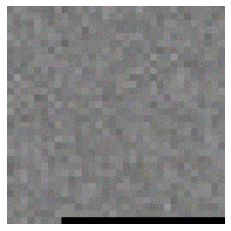

In [325]:
#Bonus content after the credits roll -
#visualize your weights!
#Function from Stanford's computer vision course
#Not particularly meaningful, but cool to see!
#You can build this into a loop to see how weights change each iteration,
#just like we do above with the training accuracy.


from math import sqrt, ceil

def visualize_grid(Xs, ubound=255.0, padding=1):
    """
    Reshape a 4D tensor of image data to a grid for easy visualization.

    Inputs:
    - Xs: Data of shape (N, H, W, C)
    - ubound: Output grid will have values scaled to the range [0, ubound]
    - padding: The number of blank pixels between elements of the grid
    """
    (N, H, W, C) = Xs.shape
    grid_size = int(ceil(sqrt(N)))
    grid_height = H * grid_size + padding * (grid_size - 1)
    grid_width = W * grid_size + padding * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C))
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = Xs[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = ubound * (img - low) / (high - low)
                next_idx += 1
            x0 += W + padding
            x1 += W + padding
        y0 += H + padding
        y1 += H + padding
    return grid

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=0).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(myNet)